# Line detection
### Traditional computer vision approach

This book designed to test feasibility of traditional computer vision techniques to detect the boundaries of the field.

In [1]:
import cv2
from cv2 import imread, cvtColor, COLOR_BGR2RGB
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
from ipywidgets import interact
%matplotlib inline

### Visualize test images

/Users/alexp/miniconda3/envs/AI_Development_CPU/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


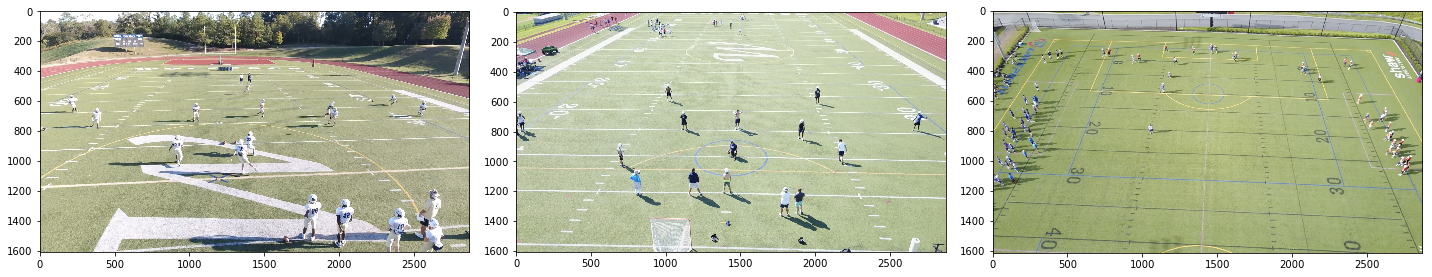

In [2]:
# load and show a test images
im_paths = glob("Test_Images/*.png")
ims = list(map(lambda x: cvtColor(imread(x), COLOR_BGR2RGB), im_paths))

f, s = plt.subplots(1, len(ims), figsize=[20,10])
for i in range(len(s)):
    s[i].imshow(ims[i])
f.tight_layout()
f.show()

### Line detection
Let's check what would be the best combination of color filters and thresholds

In [3]:
# Create a function to test various color filters
def color_maps(im, cmap):
    maps = {'rgb': None,'hls': cv2.COLOR_RGB2HLS, 'yuv': cv2.COLOR_RGB2YUV, "luv": cv2.COLOR_RGB2LUV, "lab": cv2.COLOR_RGB2LAB}
    assert cmap in maps.keys(), "Wrong color scheme provided {}. Available options are {}".format(cmap, maps.keys())
    cmap_im = cvtColor(im, maps[cmap]) if maps[cmap] is not None else im
    return cv2.split(cmap_im)

def thresholding(im, threshold):
    mask = np.zeros_like(im).astype(np.float32)
    mask[np.logical_or(im<threshold[0], im>threshold[1])] = 1.0
    return mask
    

def present_filters(im, cmaps, thresh_min, thresh_max):
    
    c1, c2, c3 = color_maps(im, cmaps)
    c1 = thresholding(c1, (thresh_min, thresh_max))
    c2 = thresholding(c2, (thresh_min, thresh_max))
    c3 = thresholding(c3, (thresh_min, thresh_max))
    
    im_list = [im, c1, c2, c3]
    f, s = plt.subplots(2,2, figsize=[20, 15])
    counter = 0
    for i in range(len(s)):
        for j in range(len(s[0])):
            im2plot = im_list[counter]
            s[i][j].set_title(cmaps[counter-1] if counter>0 else 'rgb')
            s[i][j].imshow(im2plot) if len(im2plot.shape)==3 else s[i][j].imshow(im2plot, cmap='gray')
            counter += 1
    
    f.tight_layout()
    f.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.<lambda>>

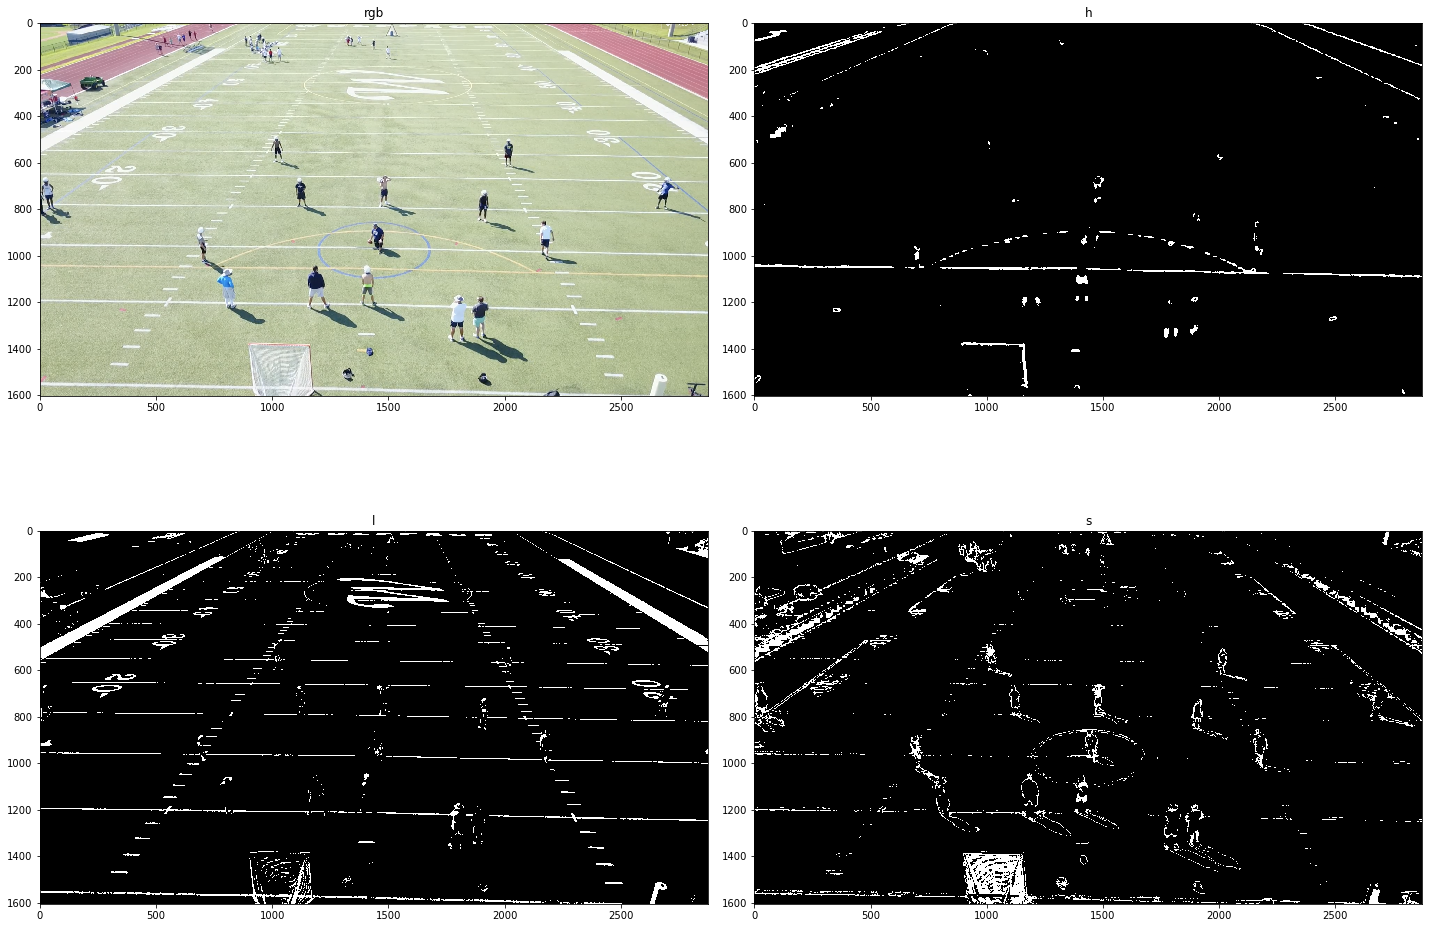

In [4]:
f = lambda im_id=1, cmap='hls', thresh_min=30, thresh_max=230: present_filters(ims[im_id], cmap, thresh_min, thresh_max)
interact(f, im_id=[0,1,2], cmap=['hls','rgb','yuv', 'luv', 'lab'],
         thresh_min=(0,254,1),
         thresh_max=(1,255,1))

The HLS representation of an image presented above prove that **L (light)** channel can provide important information.

### The next step is detecting lines with HoughLines method

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the screen.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [6]:
rho=1
theta=np.pi/180
min_line_len = int(ims[1].shape[0]/3)
threshold = int(min_line_len/2)
max_line_gap = int(min_line_len/2)

_, light_channel, _ = color_maps(ims[1], 'hls')
light_channel = thresholding(light_channel, (25, 235))
light_channel -= light_channel.min()
light_channel = (255 * light_channel / light_channel.max()).astype(np.uint8)
light_channel = cv2.GaussianBlur(light_channel, (7, 7), 0)
detected_lines = cv2.HoughLinesP(light_channel, rho, theta, threshold, min_line_len, max_line_gap)

/Users/alexp/miniconda3/envs/AI_Development_CPU/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


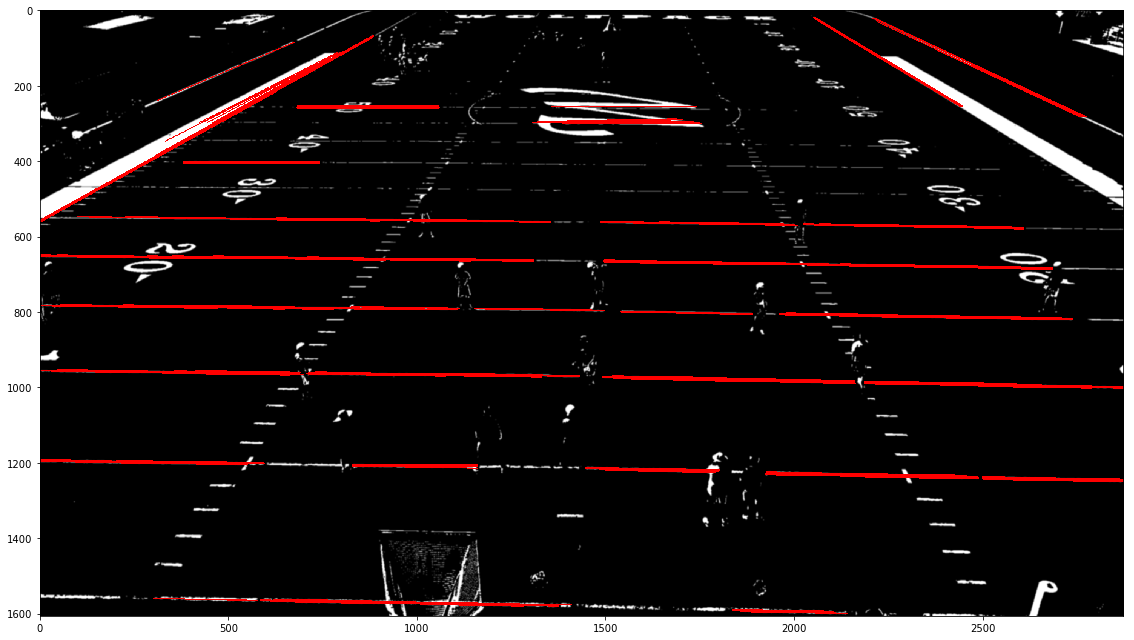

In [7]:
resulting_img = cv2.merge([light_channel,light_channel,light_channel])
draw_lines(resulting_img, detected_lines, thickness=2)
f = plt.figure(figsize=(20,9))
plt.imshow(resulting_img)
f.tight_layout()
f.show()